# 

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pandas as pd
import os
import sys
from typing import Sequence, Dict, Any, Tuple, get_args
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [3]:
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), ".."))

In [4]:
from certainty import EventSentence, load_file, convert_events, EventType, bootstrap_metrics

In [5]:
ace_train = load_file("en_train.json")
ace_dev = load_file("en_dev.json")
ace_test = load_file("en_test.json")

In [6]:
[x for x in ace_train if len(x['events']) > 0 and len(x["events"][0]["arguments"]) > 10][0]

{'sent_id': 'nw/APW_ENG_20030513.0139/006',
 'text': 'A U.S. military official in Seoul , speaking on condition of anonymity , said Tuesday North Korea is believed to have exported US$ 580 million worth of missiles to Iran , Pakistan , Libya , Syria , Egypt , Yemen and the United Arab Emirates in 2001',
 'events': [{'event_type': 'Transfer-Ownership',
   'event_polarity': 'Positive',
   'event_genericity': 'Specific',
   'event_modality': 'Other',
   'trigger': [['exported'], ['118:126']],
   'arguments': [[['North Korea'], ['86:97'], 'Seller'],
    [['US$ 580 million'], ['127:142'], 'Price'],
    [['missiles'], ['152:160'], 'Artifact'],
    [['Iran'], ['164:168'], 'Buyer'],
    [['Pakistan'], ['171:179'], 'Buyer'],
    [['Libya'], ['182:187'], 'Buyer'],
    [['Syria'], ['190:195'], 'Buyer'],
    [['Egypt'], ['198:203'], 'Buyer'],
    [['Yemen'], ['206:211'], 'Buyer'],
    [['the United Arab Emirates'], ['216:240'], 'Buyer'],
    [['2001'], ['244:248'], 'Time-Within']]}]}

In [7]:
train_df = pd.DataFrame(ace_train).drop_duplicates('text').drop_duplicates('events')
dev_df = pd.DataFrame(ace_dev).drop_duplicates('text').drop_duplicates('events')
test_df = pd.DataFrame(ace_test).drop_duplicates('text').drop_duplicates('events')

In [8]:
print(pd.DataFrame({"Train": [len(train_df)], "Validation": [len(dev_df)], "Test": [len(test_df)]}).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Train &  Validation &  Test \\
\midrule
0 &   3246 &         347 &   293 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/4039068552.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame({"Train": [len(train_df)], "Validation": [len(dev_df)], "Test": [len(test_df)]}).to_latex())


In [9]:
train_events: Sequence[EventSentence] = list(convert_events(train_df.to_dict('records')))
dev_events: Sequence[EventSentence] = list(convert_events(dev_df.to_dict('records')))
test_events: Sequence[EventSentence] = list(convert_events(test_df.to_dict('records')))

In [10]:
print(pd.DataFrame({"Train events": [len(train_events)], "Validation events": [len(dev_events)], "Test": [len(test_events)]}).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Train events &  Validation events &  Test \\
\midrule
0 &          4261 &                496 &   424 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/2091171148.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame({"Train events": [len(train_events)], "Validation events": [len(dev_events)], "Test": [len(test_events)]}).to_latex())


In [11]:
edf = pd.DataFrame(train_events)
vedf = pd.DataFrame(dev_events)
tedf = pd.DataFrame(test_events)

In [12]:
edf.head()

,sent_id,text,type,modality,label,polarity,genericity,trigger,trigger_idx,arguments
0,bc/CNN_IP_20030329.1600.02/001,It was in northern Iraq today that an eight ar...,Attack,Asserted,1,Positive,Specific,hit,60:63,"[[[northern Iraq], [10:23], Place], [[today], ..."
1,bc/CNN_IP_20030329.1600.02/002,A day ago it was controlled by Iraqi troops an...,Transport,Asserted,1,Positive,Specific,drive,92:97,"[[[it], [10:12], Destination], [[now], [81:84]..."
2,bc/CNN_IP_20030329.1600.02/003,That 's because coalition fighter jets pummele...,Attack,Asserted,1,Positive,Specific,pummeled,39:47,"[[[coalition fighter jets], [16:38], Instrumen..."
3,bc/CNN_IP_20030329.1600.02/003,That 's because coalition fighter jets pummele...,Transport,Asserted,1,Positive,Specific,retreat,128:135,"[[[the hills above Chamchamal], [71:97], Origi..."
4,bc/CNN_IP_20030329.1600.02/004,I 'm glad to see them go this one says,Transport,Asserted,1,Positive,Specific,go,22:24,"[[[them], [17:21], Artifact]]"


In [13]:
counts = pd.DataFrame()
counts['Train'] = edf['modality'].value_counts()
counts['Validation'] = vedf['modality'].value_counts()
counts['Test'] = tedf['modality'].value_counts()

In [14]:
counts = counts.T

In [15]:
counts['ratio'] = counts['Asserted'] / counts['Other']

In [16]:
print(counts.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Asserted &  Other &     ratio \\
\midrule
Train      &      3216 &   1045 &  3.077512 \\
Validation &       356 &    140 &  2.542857 \\
Test       &       308 &    116 &  2.655172 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/1484047370.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(counts.to_latex())


In [17]:
generic_events = edf[edf['genericity'] == 'Generic']['modality']

In [18]:
negative_polarity = edf[edf['polarity'] == 'Negative']

In [19]:
ncounts = pd.DataFrame()
ncounts['Train'] = edf['polarity'].value_counts()
ncounts['Validation'] = vedf['polarity'].value_counts()
ncounts['Test'] = tedf['polarity'].value_counts()
ncounts = ncounts.T
ncounts['Ratio'] = ncounts['Positive'] / ncounts['Negative']

In [20]:
print(ncounts.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Positive &  Negative &      Ratio \\
\midrule
Train      &      4103 &       158 &  25.968354 \\
Validation &       480 &        16 &  30.000000 \\
Test       &       412 &        12 &  34.333333 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/3657723705.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ncounts.to_latex())


In [21]:
negative_polarity['modality'].value_counts()

Asserted    81
Other       77
Name: modality, dtype: int64

In [22]:
print(negative_polarity[negative_polarity['modality'] == 'Other'].head().iloc[4].text)
print()
print(negative_polarity[negative_polarity['modality'] == 'Other'].head().iloc[4].trigger)

He looked for the gunshot wounds for the knife stabbing , and there is no injury whatsoever

injury


In [23]:
print(negative_polarity[negative_polarity['modality'] == 'Asserted'].head().iloc[3].text)
print()
print(negative_polarity[negative_polarity['modality'] == 'Asserted'].head().iloc[3].trigger)

It has refused in the last five years to revoke the license of a single doctor for committing medical errors

revoke


In [24]:
positive_polarity = edf[edf['polarity'] == 'Positive']

In [25]:
print(pd.concat([edf.groupby(['polarity','modality']).size(),
           vedf.groupby(['polarity','modality']).size(),
           tedf.groupby(['polarity','modality']).size()],
         keys=["Train", "Validation", "Test"]).to_latex())

\begin{tabular}{lllr}
\toprule
     &          &       &     0 \\
{} & polarity & modality &       \\
\midrule
Train & Negative & Asserted &    81 \\
     &          & Other &    77 \\
     & Positive & Asserted &  3135 \\
     &          & Other &   968 \\
Validation & Negative & Asserted &     3 \\
     &          & Other &    13 \\
     & Positive & Asserted &   353 \\
     &          & Other &   127 \\
Test & Negative & Asserted &     7 \\
     &          & Other &     5 \\
     & Positive & Asserted &   301 \\
     &          & Other &   111 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/1659281645.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  keys=["Train", "Validation", "Test"]).to_latex())


In [26]:
generic = edf[edf['genericity'] == 'Generic']

In [27]:
print(generic.iloc[3].text)
print(generic.iloc[3].trigger)
print(generic.iloc[3].modality)

It is an elementary fact of life during wartime : A press pass provides no protection
wartime
Asserted


In [28]:
i = 8
print(generic.iloc[i].text)
print(generic.iloc[i].trigger)
print(generic.iloc[i].modality)

Reporters who ignore or distort facts are betraying their craft no matter what and no matter how much that may anger the people running a war
war
Other


In [29]:
print(pd.concat([edf.groupby(['genericity','modality']).size(),
           vedf.groupby(['genericity','modality']).size(),
           tedf.groupby(['genericity','modality']).size()],
         keys=["Train", "Validation", "Test"]).to_latex())

\begin{tabular}{lllr}
\toprule
     &          &       &     0 \\
{} & genericity & modality &       \\
\midrule
Train & Generic & Asserted &   481 \\
     &          & Other &   491 \\
     & Specific & Asserted &  2735 \\
     &          & Other &   554 \\
Validation & Generic & Asserted &    45 \\
     &          & Other &    77 \\
     & Specific & Asserted &   311 \\
     &          & Other &    63 \\
Test & Generic & Asserted &    20 \\
     &          & Other &    36 \\
     & Specific & Asserted &   288 \\
     &          & Other &    80 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/1853974157.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  keys=["Train", "Validation", "Test"]).to_latex())


In [30]:
def new_factuality(row):
    if (row['modality'] == 'Asserted' and row['genericity'] == 'Generic'):
        return 'Other'
    elif (row['polarity'] == 'Negative' and row['modality'] == 'Asserted'):
        return 'Asserted-'
    elif (row['modality'] == 'Asserted' and row['polarity'] == 'Positive'):
        return 'Asserted+'
    else:
        return 'Other'

In [31]:
edf['factuality'] = edf.apply(new_factuality, axis=1)
vedf['factuality'] = vedf.apply(new_factuality, axis=1)
tedf['factuality'] = tedf.apply(new_factuality, axis=1)

In [32]:
print(pd.concat([edf['factuality'].value_counts(),
           vedf['factuality'].value_counts(),
           tedf['factuality'].value_counts()],
         keys=["Train", "Validation", "Test"]).to_latex())

\begin{tabular}{llr}
\toprule
     &           &  factuality \\
\midrule
Train & Asserted+ &        2682 \\
     & Other &        1526 \\
     & Asserted- &          53 \\
Validation & Asserted+ &         309 \\
     & Other &         185 \\
     & Asserted- &           2 \\
Test & Asserted+ &         286 \\
     & Other &         136 \\
     & Asserted- &           2 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/3455327382.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  keys=["Train", "Validation", "Test"]).to_latex())


In [33]:
ncounts = pd.DataFrame()
ncounts['Train'] = edf['factuality'].value_counts()
ncounts['Validation'] = vedf['factuality'].value_counts()
ncounts['Test'] = tedf['factuality'].value_counts()
ncounts = ncounts.T
ncounts['Asserted+ / Asserted-'] = ncounts['Asserted+'] / ncounts['Asserted-']
ncounts['Asserted+ / Other'] = ncounts['Asserted+'] / ncounts['Other']
ncounts['Other / Asserted-'] = ncounts['Other'] / ncounts['Asserted-']

In [34]:
print(ncounts.T.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &        Train &  Validation &        Test \\
\midrule
Asserted+             &  2682.000000 &   309.00000 &  286.000000 \\
Other                 &  1526.000000 &   185.00000 &  136.000000 \\
Asserted-             &    53.000000 &     2.00000 &    2.000000 \\
Asserted+ / Asserted- &    50.603774 &   154.50000 &  143.000000 \\
Asserted+ / Other     &     1.757536 &     1.67027 &    2.102941 \\
Other / Asserted-     &    28.792453 &    92.50000 &   68.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/3677880152.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ncounts.T.to_latex())


In [35]:
print(pd.concat([edf['trigger'].value_counts()[:10],
       vedf['trigger'].value_counts()[:10],
       tedf['trigger'].value_counts()[:10],
      ], keys=["Train","Validation", "Test"]).to_latex())

\begin{tabular}{llr}
\toprule
     &      &  trigger \\
\midrule
Train & war &      240 \\
     & killed &      121 \\
     & attack &       58 \\
     & election &       53 \\
     & fighting &       52 \\
     & died &       50 \\
     & trial &       49 \\
     & meeting &       46 \\
     & death &       44 \\
     & fire &       43 \\
Validation & war &       46 \\
     & attack &       14 \\
     & attacks &       14 \\
     & killed &       12 \\
     & death &       10 \\
     & meeting &        8 \\
     & genocide &        7 \\
     & wounded &        7 \\
     & shot &        7 \\
     & meetings &        7 \\
Test & war &       37 \\
     & meeting &       14 \\
     & talks &       11 \\
     & summit &        9 \\
     & divorce &        8 \\
     & sentence &        7 \\
     & appeal &        6 \\
     & elections &        6 \\
     & killed &        5 \\
     & sell &        5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/2260973393.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ], keys=["Train","Validation", "Test"]).to_latex())


In [36]:
import numpy as np

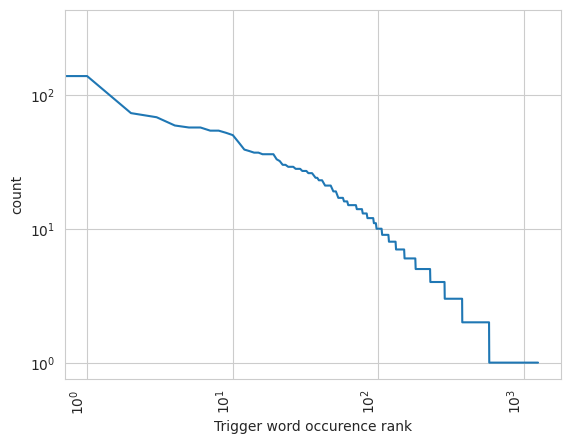

In [37]:
sns.set_style("whitegrid", {'axes.grid' : True})
temp = pd.concat([edf, vedf, tedf])
trigger_counts = temp.trigger.value_counts()
df = trigger_counts.reset_index()
df.columns = ['trigger', 'count']

plot = sns.lineplot(data=df['count'])
plt.xticks(rotation=90, ha='right')  # Rotate word labels for better readability
plt.xlabel("Trigger word occurence rank")
plot.set(yscale='log')
plot.set(xscale='log')
fig = plot.get_figure()
fig.savefig("../results/trigger_word_dist.png", bbox_inches='tight')

In [38]:
(edf['trigger'].value_counts() < 2).sum()

584

In [39]:
print(pd.DataFrame({"count = 1 trigger words": [len(df[df['count'] < 2]), (vedf['trigger'].value_counts() < 2).sum(), (tedf['trigger'].value_counts() < 2).sum()],
                    "count > 1 trigger words": [len(df[(df['count'] >= 2)]), (vedf['trigger'].value_counts() >= 2).sum(), (tedf['trigger'].value_counts() >= 2).sum()]}).T.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    0 &    1 &    2 \\
\midrule
count = 1 trigger words &  671 &  169 &  155 \\
count > 1 trigger words &  575 &   76 &   78 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/3895439838.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  "count > 1 trigger words": [len(df[(df['count'] >= 2)]), (vedf['trigger'].value_counts() >= 2).sum(), (tedf['trigger'].value_counts() >= 2).sum()]}).T.to_latex())


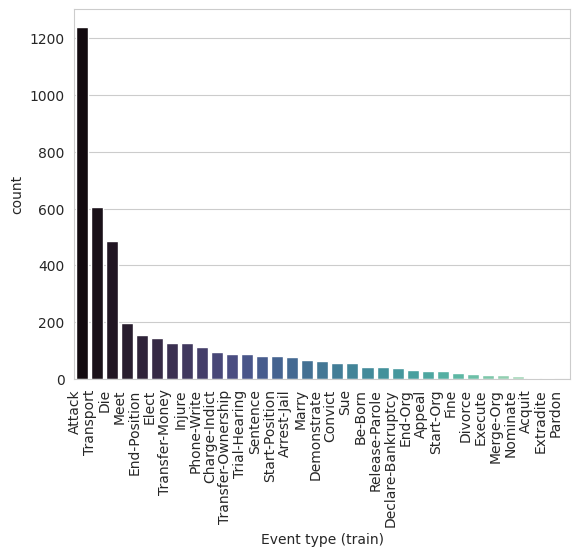

In [40]:
sns.set_style("whitegrid", {'axes.grid' : True})
plot = sns.countplot(data=edf, x="type", order = edf['type'].value_counts().index, palette="mako")
plt.xticks(rotation=90, ha='right')  # Rotate word labels for better readability
plt.xlabel("Event type (train)")
#plot.set(yscale='log')
fig = plot.get_figure()
fig.savefig("../results/type_dist.png", bbox_inches='tight')

In [41]:
edf['type'].value_counts()

Attack                1239
Transport              607
Die                    487
Meet                   198
End-Position           156
Elect                  145
Transfer-Money         128
Injure                 127
Phone-Write            112
Charge-Indict           96
Transfer-Ownership      90
Trial-Hearing           90
Sentence                81
Start-Position          80
Arrest-Jail             78
Marry                   67
Demonstrate             64
Convict                 58
Sue                     55
Be-Born                 44
Release-Parole          41
Declare-Bankruptcy      38
End-Org                 31
Appeal                  30
Start-Org               29
Fine                    22
Divorce                 18
Execute                 14
Merge-Org               14
Nominate                11
Acquit                   5
Extradite                4
Pardon                   2
Name: type, dtype: int64

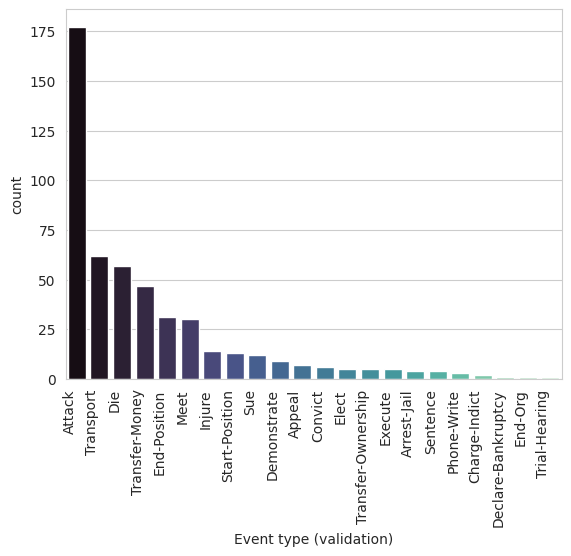

In [42]:
sns.set_style("whitegrid", {'axes.grid' : True})
plot = sns.countplot(data=vedf, x="type", order = vedf['type'].value_counts().index, palette="mako")
plt.xticks(rotation=90, ha='right')  # Rotate word labels for better readability
plt.xlabel("Event type (validation)")
#plot.set(yscale='log')
fig = plot.get_figure()
fig.savefig("../results/vtype_dist.png", bbox_inches='tight')

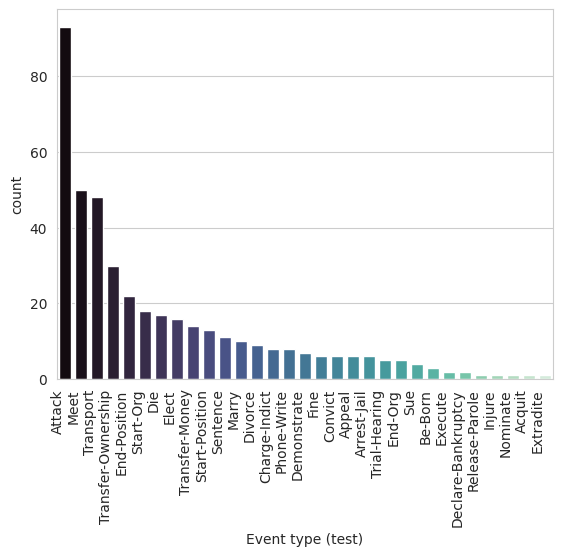

In [43]:
sns.set_style("whitegrid", {'axes.grid' : True})
plot = sns.countplot(data=tedf, x="type", order = tedf['type'].value_counts().index, palette="mako")
plt.xticks(rotation=90, ha='right')  # Rotate word labels for better readability
plt.xlabel("Event type (test)")
#plot.set(yscale='log')
fig = plot.get_figure()
fig.savefig("../results/ttype_dist.png", bbox_inches='tight')

In [44]:
print((edf['type'].value_counts()/len(edf['type'])*100).round(2).to_latex())
print("\\quad")
print((vedf['type'].value_counts()/len(vedf['type'])*100).round(2).to_latex())
print("\\quad")
print((tedf['type'].value_counts()/len(tedf['type'])*100).round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &   type \\
\midrule
Attack             &  29.08 \\
Transport          &  14.25 \\
Die                &  11.43 \\
Meet               &   4.65 \\
End-Position       &   3.66 \\
Elect              &   3.40 \\
Transfer-Money     &   3.00 \\
Injure             &   2.98 \\
Phone-Write        &   2.63 \\
Charge-Indict      &   2.25 \\
Transfer-Ownership &   2.11 \\
Trial-Hearing      &   2.11 \\
Sentence           &   1.90 \\
Start-Position     &   1.88 \\
Arrest-Jail        &   1.83 \\
Marry              &   1.57 \\
Demonstrate        &   1.50 \\
Convict            &   1.36 \\
Sue                &   1.29 \\
Be-Born            &   1.03 \\
Release-Parole     &   0.96 \\
Declare-Bankruptcy &   0.89 \\
End-Org            &   0.73 \\
Appeal             &   0.70 \\
Start-Org          &   0.68 \\
Fine               &   0.52 \\
Divorce            &   0.42 \\
Execute            &   0.33 \\
Merge-Org          &   0.33 \\
Nominate           &   0.26 \\
Acquit           

/tmp/ipykernel_12080/33503938.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((edf['type'].value_counts()/len(edf['type'])*100).round(2).to_latex())
/tmp/ipykernel_12080/33503938.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((vedf['type'].value_counts()/len(vedf['type'])*100).round(2).to_latex())
/tmp/ipykernel_12080/33503938.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex`

In [45]:
print(edf.groupby(['trigger', 'type']).size().sort_values(ascending=False)[:10].to_latex())
print("\\quad")
print(vedf.groupby(['trigger', 'type']).size().sort_values(ascending=False)[:10].to_latex())
print("\\quad")
print(tedf.groupby(['trigger', 'type']).size().sort_values(ascending=False)[:10].to_latex())

\begin{tabular}{llr}
\toprule
        &        &    0 \\
trigger & type &      \\
\midrule
war & Attack &  236 \\
killed & Die &  116 \\
attack & Attack &   58 \\
election & Elect &   53 \\
fighting & Attack &   52 \\
trial & Trial-Hearing &   49 \\
died & Die &   49 \\
meeting & Meet &   46 \\
death & Die &   44 \\
attacks & Attack &   42 \\
\bottomrule
\end{tabular}

\quad
\begin{tabular}{llr}
\toprule
          &         &   0 \\
trigger & type &     \\
\midrule
war & Attack &  45 \\
attacks & Attack &  14 \\
attack & Attack &  14 \\
killed & Die &  12 \\
death & Die &  10 \\
meeting & Meet &   8 \\
wounded & Injure &   7 \\
genocide & Attack &   7 \\
meetings & Meet &   7 \\
convicted & Convict &   6 \\
\bottomrule
\end{tabular}

\quad
\begin{tabular}{llr}
\toprule
         &        &   0 \\
trigger & type &     \\
\midrule
war & Attack &  36 \\
meeting & Meet &  14 \\
talks & Meet &  11 \\
summit & Meet &   9 \\
divorce & Divorce &   8 \\
sentence & Sentence &   7 \\
appeal & Appe

/tmp/ipykernel_12080/1296614489.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(edf.groupby(['trigger', 'type']).size().sort_values(ascending=False)[:10].to_latex())
/tmp/ipykernel_12080/1296614489.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vedf.groupby(['trigger', 'type']).size().sort_values(ascending=False)[:10].to_latex())
/tmp/ipykernel_12080/1296614489.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base 

In [46]:
e = set(edf['type'].unique())
ve = set(vedf['type'].unique())
te = set(tedf['type'].unique())

In [47]:
print(pd.DataFrame({"Train/Validation types": list(e - ve)}).to_latex())
print(pd.DataFrame({"Train/Test types": list(e - te)}).to_latex())

\begin{tabular}{ll}
\toprule
{} & Train/Validation types \\
\midrule
0  &                  Marry \\
1  &         Release-Parole \\
2  &              Start-Org \\
3  &                Divorce \\
4  &              Merge-Org \\
5  &                Be-Born \\
6  &              Extradite \\
7  &                 Pardon \\
8  &                   Fine \\
9  &                 Acquit \\
10 &               Nominate \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
{} & Train/Test types \\
\midrule
0 &           Pardon \\
1 &        Merge-Org \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/1891139039.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame({"Train/Validation types": list(e - ve)}).to_latex())
/tmp/ipykernel_12080/1891139039.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame({"Train/Test types": list(e - te)}).to_latex())


In [48]:
import spacy
nlp = spacy.load("en_core_web_sm")

/home/peder/.local/lib/python3.10/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/peder/.local/lib/python3.10/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
2025-03-26 09:50:02.328496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 09:50:02.489709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 09:50:03.874412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-03-26 09:50:04.873637: I tensorflow/compiler/xl

In [49]:
edf

,sent_id,text,type,modality,label,polarity,genericity,trigger,trigger_idx,arguments,factuality
0,bc/CNN_IP_20030329.1600.02/001,It was in northern Iraq today that an eight ar...,Attack,Asserted,1,Positive,Specific,hit,60:63,"[[[northern Iraq], [10:23], Place], [[today], ...",Asserted+
1,bc/CNN_IP_20030329.1600.02/002,A day ago it was controlled by Iraqi troops an...,Transport,Asserted,1,Positive,Specific,drive,92:97,"[[[it], [10:12], Destination], [[now], [81:84]...",Asserted+
2,bc/CNN_IP_20030329.1600.02/003,That 's because coalition fighter jets pummele...,Attack,Asserted,1,Positive,Specific,pummeled,39:47,"[[[coalition fighter jets], [16:38], Instrumen...",Asserted+
3,bc/CNN_IP_20030329.1600.02/003,That 's because coalition fighter jets pummele...,Transport,Asserted,1,Positive,Specific,retreat,128:135,"[[[the hills above Chamchamal], [71:97], Origi...",Asserted+
4,bc/CNN_IP_20030329.1600.02/004,I 'm glad to see them go this one says,Transport,Asserted,1,Positive,Specific,go,22:24,"[[[them], [17:21], Artifact]]",Asserted+
...,...,...,...,...,...,...,...,...,...,...,...
4256,wl/MARKBACKER_20050217.0647/002,"That means no team would own any player , and ...",Start-Position,Other,0,Positive,Generic,sign,74:78,"[[[whomever they 'd like], [79:100], Person]]",Other
4257,wl/MARKBACKER_20041206.0733/001,"A year ago , the program was in disarray and t...",End-Position,Other,0,Positive,Specific,fired,106:111,"[[[A year ago], [0:10], Time-Within], [[the pr...",Other
4258,wl/MARKBACKER_20041206.0733/002,"This despite several late hits to the head , l...",Attack,Asserted,1,Positive,Specific,hits,26:30,"[[[his], [57:60], Target]]",Asserted+
4259,wl/MARKBACKER_20041206.0733/002,"This despite several late hits to the head , l...",Attack,Asserted,1,Positive,Specific,hits,49:53,"[[[his], [57:60], Target]]",Asserted+


In [246]:

def get_trigger_pos(text, trigger, trigger_offset):
    """
    Get the POS tag for a trigger word at a specific offset in text
    
    Args:
        text: The full text string
        trigger: The trigger word/phrase
        trigger_offset: The character offset of the trigger in the text
    
    Returns:
        The POS tag of the trigger
    """
    # Process the text with spaCy
    doc = nlp(text)
    
    # Calculate the span of the trigger
    trigger_start = int(trigger_offset.split(":")[0])
    trigger_end = int(trigger_offset.split(":")[1])
    
    # Find the token that overlaps with the trigger
    trigger_token = None
    for token in doc:
        # Check if this token overlaps with our trigger
        token_start = token.idx
        token_end = token.idx + len(token.text)
        
        # If there's an overlap and it's the main token (in case trigger has multiple tokens)
        if (token_start <= trigger_start < token_end) or (token_start < trigger_end <= token_end) or \
           (trigger_start <= token_start and token_end <= trigger_end):
            trigger_token = token
            break
    
    char_span = doc.char_span(trigger_start, trigger_end)
    i = 0
    pos = ""
    for token in char_span:
        if i == 0:
            pos += token.pos_
        i += 1
    if i > 1:
        pos = 'COMPLEX'

    return pos
            

def add_pos_column(df):
    df['trigger_pos'] = df.apply(
        lambda row: get_trigger_pos(
            row['text'], 
            row['trigger'], 
            row['trigger_idx']
        ), 
        axis=1
    )
    return df

edf = add_pos_column(edf)
vedf = add_pos_column(vedf)
tedf = add_pos_column(tedf)

In [51]:
edf[(edf['trigger_pos'] == 'PART') | (edf['trigger_pos'] == "SCONJ")].iloc[1].trigger

'when'

In [52]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [53]:
edf['predicted'] = (edf['modality'] == 'Asserted').astype(int)

In [54]:
vedf['predicted'] = (vedf['modality'] == 'Asserted').astype(int)

In [247]:
print(edf.trigger_pos.value_counts().to_latex())
print(vedf.trigger_pos.value_counts().to_latex())
print(tedf.trigger_pos.value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &  trigger\_pos \\
\midrule
VERB    &         1964 \\
NOUN    &         1814 \\
COMPLEX &          238 \\
ADJ     &          102 \\
PRON    &           60 \\
PROPN   &           47 \\
AUX     &           16 \\
ADV     &           13 \\
ADP     &            4 \\
NUM     &            2 \\
SCONJ   &            1 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  trigger\_pos \\
\midrule
NOUN    &          238 \\
VERB    &          214 \\
COMPLEX &           19 \\
ADJ     &           12 \\
PRON    &            7 \\
PROPN   &            4 \\
AUX     &            1 \\
ADV     &            1 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  trigger\_pos \\
\midrule
NOUN    &          209 \\
VERB    &          175 \\
COMPLEX &           26 \\
ADJ     &            8 \\
PRON    &            2 \\
PROPN   &            2 \\
ADV     &            2 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/2362794772.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(edf.trigger_pos.value_counts().to_latex())
/tmp/ipykernel_12080/2362794772.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vedf.trigger_pos.value_counts().to_latex())
/tmp/ipykernel_12080/2362794772.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signat

In [56]:
edf.groupby(['trigger_pos', 'modality']).size()

trigger_pos  modality
ADJ          Asserted      97
             Other         24
ADP          Asserted       3
             Other          2
ADV          Asserted      12
             Other          2
AUX          Asserted      16
             Other          5
DET          Asserted       4
NOUN         Asserted    1406
             Other        432
NUM          Asserted      12
PART         Asserted       1
PRON         Asserted      50
             Other         11
PROPN        Asserted      52
             Other         10
SCONJ        Asserted       1
VERB         Asserted    1562
             Other        559
dtype: int64

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [217]:
all_arguments = []
cdf = pd.concat([edf, vedf, tedf])
for i in range(len(cdf)):
    arguments = cdf['arguments'].iloc[i]
    doc = nlp(cdf['text'].iloc[i])
    
    
    for argument in arguments:
        idx = argument[1][0]
        trigger_start = int(idx.split(":")[0])
        trigger_end = int(idx.split(":")[1])
        
        trigger_token = None
        for token in doc:
            token_start = token.idx
            token_end = token.idx + len(token.text)
            
            if (token_start <= trigger_start < token_end) or (token_start < trigger_end <= token_end) or \
               (trigger_start <= token_start and token_end <= trigger_end):
                trigger_token = token
                break
        
        char_span = doc.char_span(trigger_start, trigger_end)
        if char_span:
            i = 0
            for word in char_span:
                pos = word.pos_
                i += 1
            if i > 1:
                pos = "COMPLEX"

        form = {"argument": argument[0][0],
                "idx": idx,
                "role": argument[2],
                "pos": pos,
                "len": len(arguments),
                "trigger": cdf['trigger'].iloc[i],
                "type": cdf['type'].iloc[i],
                "modality": cdf['modality'].iloc[i]}
        all_arguments.append(form)
        

In [218]:
df = pd.DataFrame(all_arguments)

In [219]:
x = df.explode('pos')

In [221]:
print(x.pos.value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &   pos \\
\midrule
COMPLEX &  5509 \\
PROPN   &  1579 \\
PRON    &  1333 \\
NOUN    &   671 \\
ADV     &   143 \\
NUM     &   134 \\
ADJ     &   119 \\
VERB    &    14 \\
SCONJ   &    12 \\
PUNCT   &     2 \\
ADP     &     2 \\
DET     &     2 \\
AUX     &     1 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/1219982384.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(x.pos.value_counts().to_latex())


In [62]:
df.groupby(["role", "modality"]).size()

role         modality
Adjudicator  Asserted     76
             Other        26
Agent        Asserted    319
             Other       104
Artifact     Asserted    506
                        ... 
Time-Within  Other        90
Vehicle      Asserted     68
             Other        17
Victim       Asserted    522
             Other        86
Length: 70, dtype: int64

In [63]:
edf['argument_len'] = edf['arguments'].apply(len)
vedf['argument_len'] = vedf['arguments'].apply(len)
tedf['argument_len'] = tedf['arguments'].apply(len)

In [64]:
vedf['argument_len'].std()

1.3013202309325493

In [65]:
edf['argument_len'].std()

1.2256325730347446

In [66]:
edf['argument_len'].median()

2.0

In [67]:
vedf['argument_len'].median()

2.0

<AxesSubplot: >

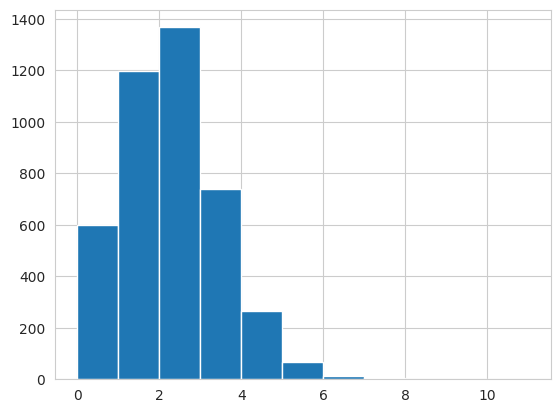

In [68]:
edf['argument_len'].hist(bins=11)

In [133]:
print(edf.argument_len.value_counts().to_latex())
print("\\quad")
print(vedf.argument_len.value_counts().to_latex())

\begin{tabular}{lr}
\toprule
{} &  argument\_len \\
\midrule
2  &          1367 \\
1  &          1199 \\
3  &           740 \\
0  &           601 \\
4  &           267 \\
5  &            66 \\
6  &            11 \\
7  &             5 \\
8  &             3 \\
10 &             1 \\
11 &             1 \\
\bottomrule
\end{tabular}

\quad
\begin{tabular}{lr}
\toprule
{} &  argument\_len \\
\midrule
1 &           138 \\
2 &           135 \\
3 &            98 \\
0 &            73 \\
4 &            37 \\
5 &            10 \\
6 &             5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/3292052419.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(edf.argument_len.value_counts().to_latex())
/tmp/ipykernel_12080/3292052419.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vedf.argument_len.value_counts().to_latex())


In [101]:
edf[edf.argument_len == 10].iloc[0]['text']

'bombardment of baghdad continues tonight and over the past 20 minutes , explosions rocking baghdad , central baghdad southern baghdad , the outskirts of baghdad , and importantly , as the coalition forces , principally u.s. army forces , move against saddam hussein international airport -- which is about ten miles outside the center of baghdad -- those explosions are intensifies'

In [102]:
edf[edf.argument_len == 10].iloc[0]['arguments']

[[['baghdad'], ['15:22'], 'Place'],
 [['tonight'], ['33:40'], 'Time-Within'],
 [['the past 20 minutes'], ['50:69'], 'Time-Holds'],
 [['central baghdad'], ['101:116'], 'Target'],
 [['southern baghdad'], ['117:133'], 'Target'],
 [['the outskirts of baghdad'], ['136:160'], 'Target'],
 [['the coalition forces'], ['184:204'], 'Attacker'],
 [['u.s. army forces'], ['219:235'], 'Attacker'],
 [['u.s. army'], ['219:228'], 'Attacker'],
 [['saddam hussein international airport -- which is about ten miles outside the center of baghdad'],
  ['251:345'],
  'Target']]

In [103]:
edf[edf.argument_len == 10].iloc[0]['type']

'Attack'

In [73]:
df

,argument,idx,role,pos,dep,len,trigger,type,modality
0,northern Iraq,10:23,Place,ADJ,amod,4,hit,Attack,Asserted
1,today,24:29,Time-Within,NOUN,npadvmod,4,hit,Attack,Asserted
2,an eight artillery round,35:59,Instrument,DET,det,4,hit,Attack,Asserted
3,the site occupied by Kurdish fighters near Cha...,64:117,Target,DET,det,4,hit,Attack,Asserted
4,it,10:12,Destination,PRON,nsubjpass,3,drive,Transport,Asserted
...,...,...,...,...,...,...,...,...,...
9516,Bankrupt energy giant Enron Corp,0:32,Org,ADJ,amod,1,Bankrupt,Declare-Bankruptcy,Asserted
9517,Bankrupt energy giant Enron Corp,0:32,Plaintiff,ADJ,amod,2,action,Sue,Other
9518,its own bankers,78:93,Defendant,PRON,poss,2,action,Sue,Other
9519,Enron 's principal bankers,0:26,Defendant,PROPN,poss,2,sued,Sue,Asserted


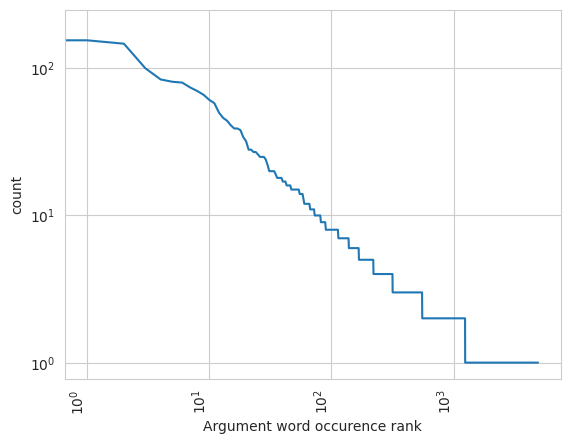

In [78]:
sns.set_style("whitegrid", {'axes.grid' : True})
temp = pd.concat([edf, vedf, tedf])
trigger_counts = df.argument.value_counts()
df = trigger_counts.reset_index()
df.columns = ['argument', 'count']

plot = sns.lineplot(data=df['count'])
plt.xticks(rotation=90, ha='right')  # Rotate word labels for better readability
plt.xlabel("Argument word occurence rank")
plot.set(yscale='log')
plot.set(xscale='log')
fig = plot.get_figure()
fig.savefig("../results/argument_word_dist.png", bbox_inches='tight')

In [79]:
print(trigger_counts[:10].to_latex())

\begin{tabular}{lr}
\toprule
{} &  argument \\
\midrule
he      &       192 \\
they    &       155 \\
Iraq    &       147 \\
we      &       100 \\
Baghdad &        84 \\
you     &        81 \\
I       &        80 \\
she     &        74 \\
him     &        70 \\
today   &        66 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/1545088848.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(trigger_counts[:10].to_latex())


In [85]:
split_len_stats = pd.DataFrame({"Split": ['Train', 'Validation'],
                                "Total": [edf['argument_len'].sum(), vedf['argument_len'].sum()],
                                "Mean+std": [str(edf['argument_len'].mean().round(3)) + "±" + str(edf['argument_len'].std().round(3)), str(vedf['argument_len'].mean().round(3)) + "±" + str(vedf['argument_len'].std().round(3))]})

In [90]:
print(split_len_stats.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
     Split &  Total &    Mean+std \\
\midrule
     Train &   7697 & 1.806±1.226 \\
Validation &    930 & 1.875±1.301 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12080/2415221485.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(split_len_stats.to_latex(index=False))


In [92]:
len(edf[edf['argument_len'] >= 4])/len(edf)

0.08307908941563014

In [100]:
edf['argument_len'].quantile(0.99)

5.0

In [124]:
print(edf.groupby(['argument_len', 'modality']).size().to_latex())
print("\\quad")
print(vedf.groupby(['argument_len', 'modality']).size().to_latex())

\begin{tabular}{llr}
\toprule
   &       &     0 \\
argument\_len & modality &       \\
\midrule
0  & Asserted &   432 \\
   & Other &   169 \\
1  & Asserted &   866 \\
   & Other &   333 \\
2  & Asserted &  1014 \\
   & Other &   353 \\
3  & Asserted &   604 \\
   & Other &   136 \\
4  & Asserted &   221 \\
   & Other &    46 \\
5  & Asserted &    63 \\
   & Other &     3 \\
6  & Asserted &    10 \\
   & Other &     1 \\
7  & Asserted &     4 \\
   & Other &     1 \\
8  & Asserted &     1 \\
   & Other &     2 \\
10 & Asserted &     1 \\
11 & Other &     1 \\
\bottomrule
\end{tabular}

\quad
\begin{tabular}{llr}
\toprule
  &          &    0 \\
argument\_len & modality &      \\
\midrule
0 & Asserted &   45 \\
  & Other &   28 \\
1 & Asserted &   90 \\
  & Other &   48 \\
2 & Asserted &  101 \\
  & Other &   34 \\
3 & Asserted &   76 \\
  & Other &   22 \\
4 & Asserted &   30 \\
  & Other &    7 \\
5 & Asserted &    9 \\
  & Other &    1 \\
6 & Asserted &    5 \\
\bottomrule
\end{tabul

/tmp/ipykernel_12080/2202779672.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(edf.groupby(['argument_len', 'modality']).size().to_latex())
/tmp/ipykernel_12080/2202779672.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(vedf.groupby(['argument_len', 'modality']).size().to_latex())


In [270]:
df = pd.DataFrame(edf.groupby(['argument_len', 'modality']).size())

In [271]:
df_reset = df.reset_index()

pivot_df = df_reset.pivot(index='argument_len', columns='modality', values=0).fillna(0)


In [272]:
percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100


In [273]:
percent_df

modality,Asserted,Other
argument_len,,
0,71.880200,28.119800
1,72.226856,27.773144
2,74.177030,25.822970
3,81.621622,18.378378
4,82.771536,17.228464
5,95.454545,4.545455
6,90.909091,9.090909
7,80.000000,20.000000
8,33.333333,66.666667


In [274]:
ratio = len(edf['modality'][edf['modality'] == 'Asserted'])/len(edf['modality'][edf['modality'] == 'Other'])

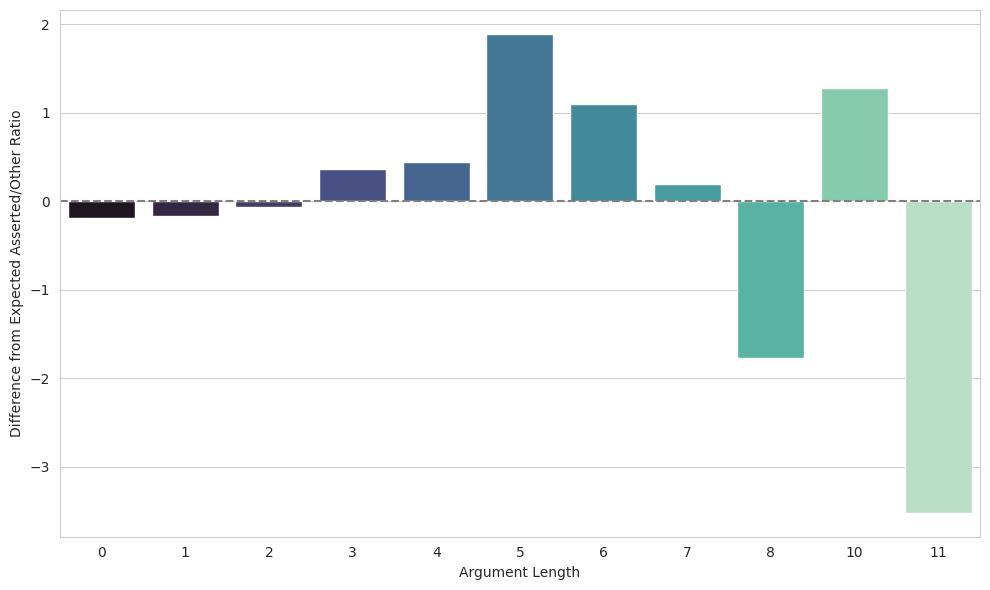

In [278]:
# Step 1: Pivot to get 'Asserted' and 'Other' counts per argument_len
pivot_df = df_reset.pivot(index='argument_len', columns='modality', values=0).fillna(0)

alpha = 0.1  # or something like 0.1 if counts are small
pivot_df['log_ratio'] = np.log((pivot_df['Asserted'] + alpha) / (pivot_df['Other'] + alpha))

# Expected ratio is 3.0775..., so expected log ratio is:
expected_log_ratio = np.log(ratio)
pivot_df['log_ratio_diff'] = pivot_df['log_ratio'] - expected_log_ratio

# Step 4: Plot the difference
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=pivot_df.index, y=pivot_df['log_ratio_diff'], palette="mako")

plt.axhline(0, color='gray', linestyle='--', label='Expected Ratio')
plt.ylabel('Difference from Expected Asserted/Other Ratio')
plt.xlabel('Argument Length')
plt.tight_layout()
fig = plot.get_figure()
fig.savefig("../results/argument_len_deviation.png", bbox_inches='tight')

In [261]:
pivot_df

modality,Asserted,Other,actual_ratio,difference_from_expected
argument_len,,,,
0,432.0,169.0,2.556213,-0.521299
1,866.0,333.0,2.600601,-0.476911
2,1014.0,353.0,2.872521,-0.204991
3,604.0,136.0,4.441176,1.363665
4,221.0,46.0,4.804348,1.726836
5,63.0,3.0,21.000000,17.922488
6,10.0,1.0,10.000000,6.922488
7,4.0,1.0,4.000000,0.922488
8,1.0,2.0,0.500000,-2.577512


In [280]:

ratio = len(vedf['modality'][vedf['modality'] == 'Asserted'])/len(vedf['modality'][vedf['modality'] == 'Other'])

In [281]:
df = pd.DataFrame(vedf.groupby(['argument_len', 'modality']).size())

In [282]:
df_reset = df.reset_index()

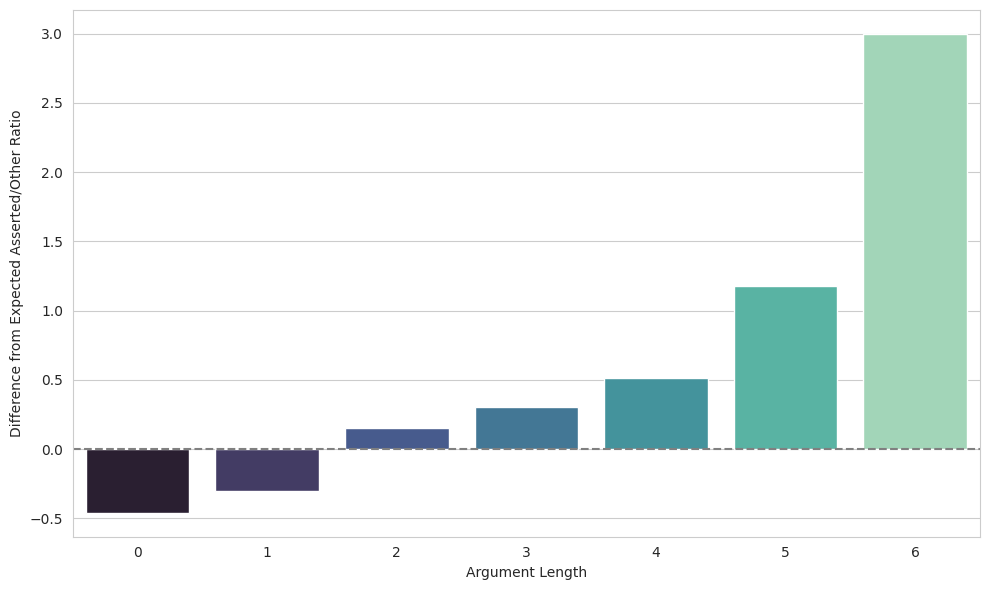

In [283]:
# Step 1: Pivot to get 'Asserted' and 'Other' counts per argument_len
pivot_df = df_reset.pivot(index='argument_len', columns='modality', values=0).fillna(0)

alpha = 0.1  # or something like 0.1 if counts are small
pivot_df['log_ratio'] = np.log((pivot_df['Asserted'] + alpha) / (pivot_df['Other'] + alpha))

# Expected ratio is 3.0775..., so expected log ratio is:
expected_log_ratio = np.log(ratio)
pivot_df['log_ratio_diff'] = pivot_df['log_ratio'] - expected_log_ratio

# Step 4: Plot the difference
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=pivot_df.index, y=pivot_df['log_ratio_diff'], palette="mako")

plt.axhline(0, color='gray', linestyle='--', label='Expected Ratio')
plt.ylabel('Difference from Expected Asserted/Other Ratio')
plt.xlabel('Argument Length')
plt.tight_layout()
fig = plot.get_figure()
fig.savefig("../results/val_argument_len_deviation.png", bbox_inches='tight')

In [285]:
pivot_df

modality,Asserted,Other,log_ratio,log_ratio_diff
argument_len,,,,
0,45.0,28.0,0.473113,-0.460176
1,90.0,48.0,0.627638,-0.305650
2,101.0,34.0,1.086813,0.153524
3,76.0,22.0,1.236471,0.303182
4,30.0,7.0,1.444430,0.511142
5,9.0,1.0,2.112964,1.179676
6,5.0,0.0,3.931826,2.998537
